<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/LotkaVolterra_full_GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full GRN in pancreas model for stellate cells and cancer cells.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53_s$ | $PIP3_s$ | $ERK_s$| $P53_c$ | $PIP3_c$ | $BCL-XL_c$ | $P21_c$ | $Apop_s$ | $Prolif_s$ | $Apop_c$ | $Prolif_c$ |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|$X_1$|$X_2$|$Y_1$|$Y_2$|$Y_3$|$Y_4$|$S_2$|$S_3$|$S_4$|$S_5$|$Z_1$|$Z_2$|$Z_3$|$Z_4$|

Considerando los tiempos de duración obtenidos para PanIN en el artículo: [Progression to pancreatic ductal adenocarcinoma from pancreatic intraepithelial neoplasia: Results of a simulation model](https://www.sciencedirect.com/science/article/pii/S1424390318306367?via%3Dihub), se tiene lo siguiente:

| **_Etapas_** 	| **_Todas las mujeres_** 	| **_Mujeres que pasan <br>a la siguiente etapa_** 	| **_Todos los hombres_** 	| **_Hombres que pasan <br>a la siguiente etapa_** 	|
|:---:	|:---:	|:---:	|:---:	|:---:	|
| Tiempo en PanIN 1<br>Años promedio <br>(IQR Q1-Q3) 	| 23.7<br>(10.3–34.9) 	| 17.4<br>(6.50–25.6) 	| 22.3<br>(9.42–32.8) 	| 16.5<br>(6.00–24.3) 	|
| Tiempo en PanIN 2<br>Años promedio <br>(IQR Q1-Q3) 	| 17.5<br>(6.50–25.7) 	| 13.9<br>(4.83–20.3) 	| 16.4<br>(6.00–24.1) 	| 13.3<br>(4.58–19.3) 	|
| Tiempo en PanIN 3<br>Años promedio <br>(IQR Q1-Q3) 	| 11.3<br>(3.75–16.3) 	| 10.0<br>(3.25–14.3) 	| 10.0<br>(3.25–14.3) 	| 9.0<br>(2.83–12.8) 	|
| Tiempo en PDAC no-detectado<br>Años promedio <br>(IQR Q1-Q3) 	|  	| 2.65<br>(1.00–3.58) 	|  	| 2.56<br>(0.92–3.50) 	|
| PanIN 1 a PDAC detectado<br>Años promedio<br>(IQR Q1-Q3) 	|  	| 35.3<br>(25.6–44.7) 	|  	| 33.6<br>(24.0–42.6) 	|
| PanIN 3 a PDAC detectado<br>Años promedio <br>(IQR Q1-Q3) 	|  	| 12.3<br>(5.75–16.8) 	|  	| 11.3<br>(5.25–15.4) 	|

Por lo que si consideramos $\tau_1$ y $\tau_2$ como directamente proporcinales al tiempo de transición de sano a PanIN 1 y al tiempo de transición de PanIN 1 a PanIN 2, respectivamente, entonces podemos decir que $\tau_1>\tau_2$.

\begin{align*}
    k_{1\to 2,H} = \frac{\tau_{2,H}}{\tau_{1,H}} = \frac{13.9\ \text{años}}{17.4\ \text{años}} = 0.798\qquad \text{(En hombres)} \\
    k_{1\to 2,M} = \frac{\tau_{2,M}}{\tau_{1,M}} = \frac{13.3\ \text{años}}{16.5\ \text{años}} = 0.807\qquad \text{(En mujeres)}
\end{align*}

Por lo que se puede considerar que constante de proporcionalidad es $k_{1\to 2} = 0.8$ en el caso general.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline
# sns.set_style("whitegrid")
sns.set_style("darkgrid")
sns.set_context("paper")

#### Se declara la función supresora/activadora del sistema de la siguiente manera:

$$ \text{supr}(e, n, s) = \frac{e}{1 + s^n}$$

In [15]:
def supr(e, n, s):
    return e/(1 + s**n)

In [16]:
def plot_supr(n):
    x = np.linspace(0.01, 2*np.pi, 2000)
    y = supr(1, n, x)
    plt.title(f"Gráfica de la función supr$(e=1,n,s)$", fontsize=12)
    plt.xlabel("s"); plt.ylabel("supr(1,n,s)")
    plt.plot(x, y); plt.show()

interact(plot_supr, n = widgets.FloatSlider(value=9.5, min=-10, max=10, step=1))

interactive(children=(FloatSlider(value=9.5, description='n', max=10.0, min=-10.0, step=1.0), Output()), _dom_…

<function __main__.plot_supr(n)>

#### Sistema de ecuaciones: Lotka-Volterra

\begin{align}
    \dot{u} &= u(1-v) \\
    \dot{v} &= \beta\ v(u-1)
\end{align}

In [3]:
# Se declaran las variables u, v que representan a TNFa y TNFb1 con comportamientos oscilantes periodicos.
# Esto se debe a la hipótesis de un ciclo de activación de citocinas oscilante.
def dS_LT(S, beta1):
    u, v = S
    du = u*(1 - v)
    dv = beta1*v*(u - 1)

    dS = np.asarray([du, dv])
    return dS

In [17]:
def RK4_LotkaVolterra(t, S0, beta1):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([2*len(t)+1, dims])

    for d in range(dims):
        S[0, d] = S0[d]

    dt = t[1] - t[0];
    for i in range(len(t)):
        K[0] = dt * dS_LT(S[i]         , beta1)
        K[1] = dt * dS_LT(S[i] + K[0]/2, beta1)
        K[2] = dt * dS_LT(S[i] + K[1]/2, beta1)
        K[3] = dt * dS_LT(S[i] + K[2]  , beta1)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S[1:len(t)+2, :]

In [18]:
def X(t, A, n, T):
    x1 = (A*(1 + np.sin(2*np.pi*t/T)))**n
    x2 = (A*(1 + np.cos(2*np.pi*t/T)))**n
    return np.array([x1, x2])

def Y(t, A, n, beta):
    y1 = (A*(1 + np.sin(t*np.sqrt(beta))))**n
    y2 = (A*(1 + np.cos(t*np.sqrt(beta))))**n
    return np.array([y1, y2])

36.94895225


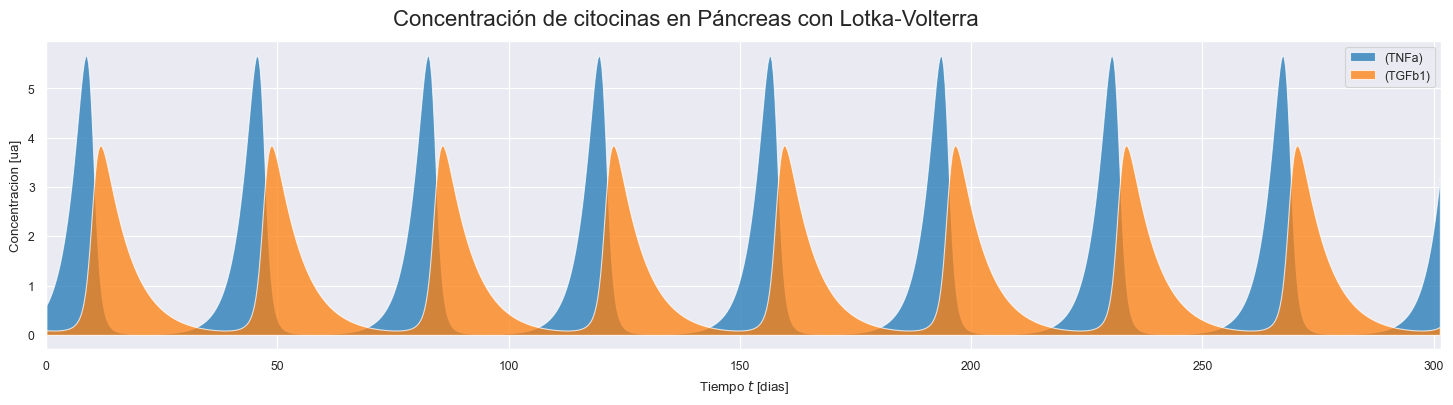

In [19]:
# Parámetros
u = .5;
v = .1;
# beta = 0.4568;
beta1, beta2 = 0.51, 0.263;
# t_begin=0*np.pi; t_end=170*np.pi; num=48000
t_begin=0*np.pi; t_end=4800; num=48000
t = np.linspace(t_begin, t_end, num)
# ut, ut_label = 0.099164, "meses"
ut, ut_label = 3.016241, "dias"

S0 = np.array([u, v])
Pip = RK4_LotkaVolterra(t, S0, beta1)
X1_LT, X2_LT= Pip[1:,0], Pip[1:,1]

plt.figure(figsize=(18,4), dpi=100)
plt.fill_between(ut * t[:1000], X1_LT[:1000], alpha=0.75, label="(TNFa)")
plt.fill_between(ut * t[:1000], X2_LT[:1000], alpha=0.75, label="(TGFb1)")
plt.xlim(t_begin*ut, t[1000]*ut);
plt.grid()

plt.ylabel("Concentracion [ua]")
plt.text(75, 6.4, f"Concentración de citocinas en Páncreas con Lotka-Volterra", va='center', fontsize=16)
plt.xlabel(f"Tiempo $t$ [{ut_label}]");
plt.legend(); plt.grid()
# -----------------

# x1, x2 = X(t, 0.5, 2.36, 12.25)
# yy1, yy2 = Y(t, 0.5, 2.36, beta2)

# plt.figure(figsize=(18,4), dpi=100)
# plt.fill_between(ut * t[:1000], x1[:1000], alpha=0.75, label="(TNFa)");
# # plt.fill_between(t*ut, x2, alpha=0.75, label="(TGFb1)");
# plt.fill_between(ut * t[:1000], yy2[:1000], alpha=0.75, label="(TGFb1)");
# # plt.xlim(t_begin*ut, t_end*ut);
# plt.xlabel(f"Tiempo, [{ut_label}]"); plt.grid()

# plt.ylabel("Amplitud, [ua]")
# plt.text(100, 1.2, f"  Ciclo de activacion de citocinas en Páncreas", va='center', fontsize=16)\

print(12.25*ut)

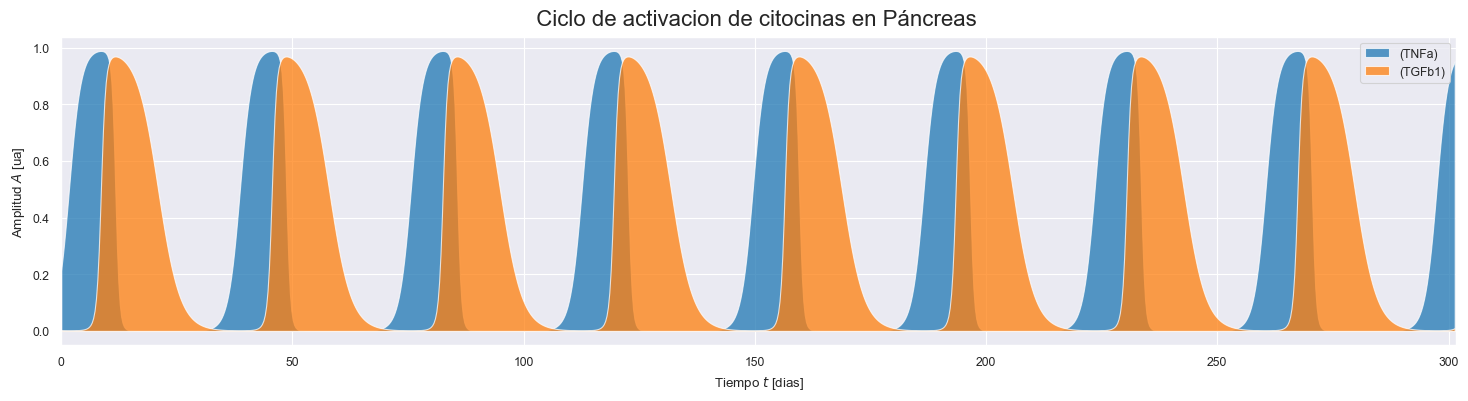

In [7]:
# ut, ut_label = 0.099164, "meses"
ut, ut_label = 3.016241, "dias"

plt.figure(figsize=(18,4), dpi=100)
plt.fill_between(ut * t[:1000], supr(1, -2.55, X1_LT[:1000]), alpha=0.75, label="(TNFa)");
plt.fill_between(ut * t[:1000], supr(1, -2.55, X2_LT[:1000]), alpha=0.75, label="(TGFb1)");
plt.grid(); plt.legend()
plt.xlim(ut * t[0], ut * t[1000])

plt.ylabel("Amplitud $A$ [ua]")
plt.text(100, 1.1, f"  Ciclo de activacion de citocinas en Páncreas", va='center', fontsize=16)
plt.xlabel(f"Tiempo $t$ [{ut_label}]"); plt.grid()

In [23]:
# Se aplican las ecuaciones dinámicas de cada variable en función de la red de regulación para cáncer de páncreas
def dS(S, i, y1_tau1, c3_tau2, X1, X2, n, e):
    y1, y2, y3, y4, c1, c2, c3, c4, z1, z2, z3, z4, Ry1, Ry2, Ry3, Ry4, Rc1, Rc2, Rc3, Rc4, Rz1, Rz2, Rz3, Rz4, Rc2a, Rc2b, c2a, c2b = S
    
    # ---------------------------GENES SANOS----------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4) + supr(0.015, n[0], c3_tau2)) - Ry1;
    dy1  = supr(1, n[1], Ry1) - y1;                                           # RAS

    dRy2 = e[1]*(supr(1, n[0], y1) + supr(1, -n[0], y2) + supr(1, -n[0], y3)) - Ry2;
    dy2  = supr(1, n[1], Ry2) - y2;                                           # P53

    dRy3 = e[2]*(supr(1, n[0], y4) + supr(1, -n[0], y2)) - Ry3;
    dy3  = supr(1, n[1], Ry3) - y3;                                           # PIP3

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;                                           # ERK
    
    # ---------------------------GENES CANCER-----------------------------
    dRc1 = e[4]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3_tau2) + supr(2, -n[0], c2)) - Rc1
    dc1  = supr(1, n[1], Rc1) - c1;                                           # BCL-XL

    dRc2a = e[5]*(supr(1, -n[0], c2) + supr(1, -n[0], c3_tau2)) - Rc2a
    dc2a  = supr(1, n[1], Rc2a) - c2a

    dRc2b = e[6]*(supr(1, n[0], c3_tau2) + supr(1, -n[0], c4)) - Rc2b
    dc2b  = supr(1, n[1], Rc2b) - c2b
    dRc2 = e[7]*(supr(1, n[0], c2a) + supr(1, n[0], c2b)) - Rc2
    dc2  = supr(1, n[1], Rc2) - c2;                                           # P53c

    dRc3 = e[8]*(supr(1, n[0], y1_tau1) + supr(1, -n[0], c2)) - Rc3
    dc3  = supr(1, n[1], Rc3) - c3;                                           # PIP3c

    dRc4 = e[9]*(supr(1, n[0], X2[i]) + supr(1, n[0], c2)) - Rc4
    dc4  = supr(1, n[1], Rc4) - c4;                                           # P21
    
    # ---------------------------FENOTIPOS CELULARES-----------------------------
    dRz2 = e[10]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2

    dRz3 = e[11]*(supr(1, -n[0], c3_tau2) * (supr(1, n[0], c2) + supr(1, -n[0], c1)) * supr(0.5, -n[0], z3)) - Rz3
    dz3  = supr(1, n[1], Rz3) - z3

    dRz4 = e[12]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3_tau2) + supr(1, -n[0], c4)) - Rz4
    dz4  = supr(1, n[1], Rz4) - z4
    
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dc1, dc2, dc3, dc4, dy2, dz2, dz3, dz4, dRy1, dRy2, dRy3, dRy4, dRc1, dRc2, dRc3, dRc4, dRy2, dRz2, dRz3, dRz4, dRc2a, dRc2b, dc2a, dc2b]
    return np.array(dS)

In [24]:
# Se define el resolvedor de ecuaciones diferenciales RK4
def RK_solver(S0, t, tau1, tau2, X1, X2, n, e):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([2*len(t)+1, dims])

    for d in range(dims):
        S[0, d] = S0[d]

    dt = t[1] - t[0];
    for i in range(len(t)):
        y1_tau1, c3_tau2 = S[i-int(tau1), 0], S[i-int(tau2), 5]
        K[0] = dt * dS(S[i]         , i, y1_tau1, c3_tau2, X1, X2, n, e)
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau1, c3_tau2, X1, X2, n, e)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau1, c3_tau2, X1, X2, n, e)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau1, c3_tau2, X1, X2, n, e)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S[1:len(t)+2, :]

In [25]:
# Parámetros de la simulación
n = [-6, -10]
e = [1/0.3, 1/2.2, 1/1, 1/0.3, 1/1.25, 1/1.4, 1/1.0, 1/0.2, 1/1, 1/1, 1/1.05, 1/0.68, 1/1.4]

# Condiciones iniciales para las variables y su primera derivada
S0 = np.concatenate([np.array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1]), np.zeros(18)])   # Y, C, Z, R

In [44]:
labels = ["RAS","P53","PIP3","ERK","BCL-XL","P53c","PIP3c","P21","ApopS","ProlifS","ApopC","ProlifC"]
# ut, ut_label = 3.016241, "dias"

def plot_full_GRN(tau1, tau2, n_exp):
    
    # Se define el factor de escala temporal para poder convertir a escalas de tiempo de meses
    esc_mes = 0.099164          # meses
    esc_dia = 3.016241          # dias
    
    # Se resuelve el sistema con X1 y X2 del sistema Lotka-Volterra
    tt, linewidth = t, 0.5 
    X1, X2 = supr(1, -n_exp/10, X1_LT), supr(1, -n_exp/10, X2_LT)
    Pip = RK_solver(S0, t, tau1, tau2, X1, X2, n, e)
    fig = plt.figure(figsize=(16,8), dpi=100); gs = fig.add_gridspec(3, hspace=0.05)
    
    # Se grafican los resultados de cada variable segun si son componentes de células sanas, cáncer y fenotipos celulares
    axs = gs.subplots()
    for i in range(4):
        # axs[0].plot(tt*esc_mes, Pip[1:,i]  , label=labels[i],   linewidth=0.5)
        axs[0].plot(tt*esc_mes, Pip[1:,i]  , label=labels[i],   linewidth=linewidth)
        axs[1].plot(tt*esc_mes, Pip[1:,i+4], label=labels[i+4], linewidth=linewidth)
        axs[2].plot(tt*esc_mes, Pip[1:,i+8], label=labels[i+8], linewidth=linewidth)
        
     # Se agregan lineas de referencia para marcar las transiciones PanIN 1 y 2.
    for i in range(3):
        axs[i].legend(loc="upper left", bbox_to_anchor=(0.924, 0.85)); axs[i].set_xlim([tt[0]*esc_mes, tt[-1]*esc_mes]);  axs[i].set_ylim([-0.05, 1.05])
        axs[i].axvline(tau2/10*esc_mes, color="black"); 
        axs[i].axvline(tau2/10*esc_mes + (tau2)*0.08*esc_mes, color="black")

    fig.text(0.35, 0.91, "  Perfil de expresión genética en Cáncer de Páncreas\n" +
             f"$T = {round(2*np.pi*1.95*esc_dia,2)}$ días,   $\Delta t_1 = {round((tau2)*step*esc_dia,1)}$ días,   $\Delta t_2 = {round((tau2)*0.8*step*esc_dia,1)}$ días",
            va='center', fontsize=16)
    plt.xlabel(r"Tiempo $t$ [meses]", fontsize=12)
    fig.text(0.09, 0.5, r"Amplitud $A$ [ua]", va='center', rotation='vertical', fontsize=12)
    plt.show()

    print(tau1*esc_mes*step, tau2*esc_mes*step)
    print(tau1*step, tau2*step)
    print(esc_mes)

In [56]:
# Parametros de la gráfica
start=0; step=0.1; num=48000
t = np.arange(0.0001, num)*step + start

interact(plot_full_GRN,
# interact(plot_full_GRN, beta = widgets.FloatSlider(value=0.263, min=0.1, max=1, step=0.01),
                     tau1 = widgets.FloatSlider(value=1584, min=100, max=5000, step=0.1),
                     tau2 = widgets.FloatSlider(value=20870, min=15000, max=25000, step=1),
                    n_exp = widgets.FloatSlider(value=25.5, min=1, max=35, step=0.1))

interactive(children=(FloatSlider(value=1584.0, description='tau1', max=5000.0, min=100.0), FloatSlider(value=…

<function __main__.plot_full_GRN(tau1, tau2, n_exp)>

In [57]:
def plot_healthy_GRN(tau1, tau2, n_exp):
    
    # Se define el factor de escala temporal para poder convertir a escalas de tiempo de meses
    esc_mes = 0.099164          # meses
    esc_dia = 3.016241          # dias
    
    # Se resuelve el sistema con X1 y X2 del sistema Lotka-Volterra
    tt = t[3000:]; ut = 0.099164
    X1, X2 = supr(1, -n_exp/10, X1_LT), supr(1, -n_exp/10, X2_LT)
    Pip = RK_solver(S0, t, tau1, tau2, X1, X2, n, e)
    fig = plt.figure(figsize=(16,5), dpi=100); gs = fig.add_gridspec(2, hspace=0.04)
    
    # Se grafican los resultados de cada variable segun si son componentes de células sanas, cáncer y fenotipos celulares
    axs = gs.subplots()
    for i in range(4):
        axs[0].plot(tt*esc_mes, Pip[3001:,i]  , label=labels[i],   linewidth=1)
        axs[1].plot(tt*esc_mes, Pip[3001:,i+8], label=labels[i+8], linewidth=1)
    
    # # Se agregan lineas de referencia para marcar las transiciones PanIN 1 y 2.
    # for i in range(2):
    #     axs[i].legend(loc="upper left", bbox_to_anchor=(0.895, 0.85)); axs[i].set_xlim([tt[0]*esc_mes, tt[-1]*esc_mes]);  axs[i].set_ylim([-0.05, 1.05])
    #     axs[i].axvline(tau2/10*esc_mes, color="black"); 
    #     axs[i].axvline(tau2/10*esc_mes + (tau2)*0.08*esc_mes, color="black")

    fig.text(0.3, 0.91, "  Perfil de expresión genética en un Páncreas sano," + f"    $T = {round(2*np.pi*1.95*esc_dia,2)}$ días",
            va='center', fontsize=16)

    plt.xlabel(r"Tiempo $t$ [meses]", fontsize=12)
    fig.text(0.08, 0.5, r"Amplitud $A$ [ua]", va='center', rotation='vertical', fontsize=12)
    plt.show()

    print(tau1*ut*step, tau2*ut*step)
    print(tau1*step, tau2*step)
    print(ut)

In [58]:
start=0; step=0.1; num=10000
t = (np.arange(0.0001, num)*step + start)
# tt = t; ut = 0.099164

interact(plot_healthy_GRN, tau1 = widgets.FloatSlider(value=1584, min=100, max=5000, step=0.1),
                           tau2 = widgets.FloatSlider(value=10870, min=1000, max=25000, step=1),
                           n_exp = widgets.FloatSlider(value=25.5, min=1, max=35, step=0.1))

interactive(children=(FloatSlider(value=1584.0, description='tau1', max=5000.0, min=100.0), FloatSlider(value=…

<function __main__.plot_healthy_GRN(tau1, tau2, n_exp)>